In [1]:
from IPython.display import display, HTML

# To display the image
display(HTML("<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>"))

# To display the heading and horizontal lines
display(HTML("<h1><hr style='border:none; height:3px;'><center>ML Supervised</center><hr style='border:none; height:3px;'></h1>"))

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Convenience function to create display a progress bar.
# Source : https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console
def print_progress_bar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total:
        print()

script_dir = Path.cwd() 
df = pd.read_csv(script_dir.parent / '4 - Dataset' / "regression_weld_data_noOutliers.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 32 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Carbon concentration (weight%)                1324 non-null   float64
 1   Silicon concentration (weight%)               1324 non-null   float64
 2   Manganese concentration (weight%)             1324 non-null   float64
 3   Sulphur concentration (weight%)               1324 non-null   float64
 4   Phosphorus concentration (weight%)            1324 non-null   float64
 5   Oxygen concentration (%)                      1324 non-null   float64
 6   Nitrogen concentration (%)                    1324 non-null   float64
 7   Current (A)                                   1324 non-null   float64
 8   Voltage (V)                                   1324 non-null   float64
 9   Heat input (kJ/mm)                            1324 non-null   f

In [151]:

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 32 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Carbon concentration (weight%)                1324 non-null   float64
 1   Silicon concentration (weight%)               1324 non-null   float64
 2   Manganese concentration (weight%)             1324 non-null   float64
 3   Sulphur concentration (weight%)               1324 non-null   float64
 4   Phosphorus concentration (weight%)            1324 non-null   float64
 5   Oxygen concentration (%)                      1324 non-null   float64
 6   Nitrogen concentration (%)                    1324 non-null   float64
 7   Current (A)                                   1324 non-null   float64
 8   Voltage (V)                                   1324 non-null   float64
 9   Heat input (kJ/mm)                            1324 non-null   f

,Carbon concentration (weight%),Silicon concentration (weight%),Manganese concentration (weight%),Sulphur concentration (weight%),Phosphorus concentration (weight%),Oxygen concentration (%),Nitrogen concentration (%),Current (A),Voltage (V),Heat input (kJ/mm),...,AC or DC,Electrode positive or negative,Type of weld,Yield strength (MPa),Ultimate tensile strength (MPa),Elongation (%),Reduction of Area (%),Charpy temperature (deg C),Charpy impact toughness (J),Hardness (kg/mm2)
0,0.042,0.28,1.37,0.007,0.012,0.0421,0.0082,170.0,21.0,2.2,...,0.0,1.0,0.0,NaN,NaN,NaN,NaN,-57.0,100.0,NaN
1,0.075,0.35,1.09,0.006,0.008,0.0424,0.0087,170.0,21.0,1.0,...,0.0,1.0,0.0,NaN,NaN,NaN,NaN,-57.0,100.0,NaN
2,0.090,0.59,1.10,0.013,0.020,0.0540,0.0082,150.0,37.5,1.0,...,0.0,1.0,0.0,648.0,743.0,18.0,58.0,NaN,NaN,247.0
3,0.078,0.43,1.10,0.007,0.005,0.0329,0.0073,170.0,21.0,1.0,...,0.0,1.0,0.0,399.0,492.0,32.2,80.7,-56.0,100.0,NaN
4,0.120,0.14,1.03,0.002,0.006,0.0166,0.0022,500.0,29.0,2.9,...,1.0,0.0,1.0,NaN,745.0,NaN,NaN,-20.0,172.0,NaN


## Création X et y

In [152]:
L_features = [
    'Carbon concentration (weight%)', 'Silicon concentration (weight%)',
       'Manganese concentration (weight%)', 'Sulphur concentration (weight%)',
       'Phosphorus concentration (weight%)', 'Nickel concentration (weight%)',
       'Chromium concentration (weight%)',
       'Molybdenum concentration (weight%)',
       'Vanadium concentration (weight%)', 'Copper concentration (weight%)',
       'Oxygen concentration (%)', 'Titanium concentration (%)',
       'Nitrogen concentration (%)', 'Aluminium concentration (%)',
       'Boron concentration (%)', 'Niobium concentration (%)', 'Current (A)',
       'Voltage (V)', 'AC or DC', 'Electrode positive or negative',
       'Heat input (kJ/mm)', 'Interpass temperature (deg C)', 'Type of weld',
       'Post weld heat treatment temperature (deg C)',
       'Post weld heat treatment time (hours)', 'Charpy temperature (deg C)'
]


L_targets = [
    'Yield strength (MPa)', 
       'Ultimate tensile strength (MPa)', 'Elongation (%)',
       'Reduction of Area (%)', 'Charpy impact toughness (J)', 'Hardness (kg/mm2)'
]


X = df.loc[:, L_features]
ys = df.loc[:,L_targets]
print(ys.info())
print(L_targets[2])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Yield strength (MPa)             1003 non-null   float64
 1   Ultimate tensile strength (MPa)  919 non-null    float64
 2   Elongation (%)                   853 non-null    float64
 3   Reduction of Area (%)            828 non-null    float64
 4   Charpy impact toughness (J)      806 non-null    float64
 5   Hardness (kg/mm2)                100 non-null    float64
dtypes: float64(6)
memory usage: 62.2 KB
None
Elongation (%)


In [153]:
from sklearn.model_selection import train_test_split

def trainTest(X,y) :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def scale(X,scaler=MinMaxScaler()) :
    scaler = scaler
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    return X_scaled




In [168]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Fonction pour calculer le RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Fonction pour calculer le R² ajusté
def calculate_adjusted_r2(r2, n, p):
    return round(1 - (1 - r2) * (n - 1) / (n - p - 1),3)

# Configuration de la validation croisée (5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Fonction générique d'entraînement et d'évaluation du modèle
def evaluate_model(model, param_grid, X_train, X_test, y_train, y_test, model_name, scoring='r2'):
    # Effectuer une recherche d'hyperparamètres aléatoire si une grille de paramètres est fournie
    if param_grid is not None:
        random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, cv=kf, random_state=42)
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_

        # Extraire les meilleurs hyperparamètres uniquement à partir de la grille fournie
        best_hyperparameters = {param: random_search.best_params_[param] for param in param_grid}
    else:
        best_model = model.fit(X_train, y_train)
        best_hyperparameters = best_model.get_params()  # Si pas de grille, prendre tous les hyperparamètres

    # Validation croisée sur l'ensemble d'entraînement
    #y_train_pred_cv = cross_val_predict(best_model, X_train, y_train, cv=kf)

    y_train_pred_cv = best_model.predict(X_train)

    # Prédictions sur l'ensemble de test
    y_test_pred = best_model.predict(X_test)

    # Calcul des scores de validation croisée
    cross_val_scores = cross_val_score(best_model, X_train, y_train, cv=kf, scoring=scoring)
    mean_cross_val_score = cross_val_scores.mean()

    # Calcul des scores de régression avec arrondi à 3 chiffres après la virgule
    rmse_train = round(calculate_rmse(y_train, y_train_pred_cv), 3)
    rmse_test = round(calculate_rmse(y_test, y_test_pred), 3)
    r2_train = round(r2_score(y_train, y_train_pred_cv), 3)
    r2_test = round(r2_score(y_test, y_test_pred), 3)

    # Calcul du MAE avec arrondi à 3 chiffres après la virgule
    mae_train = round(mean_absolute_error(y_train, y_train_pred_cv), 3)
    mae_test = round(mean_absolute_error(y_test, y_test_pred), 3)

    # Nombre d'observations et de prédicteurs
    n_train, p_train = X_train.shape

    # Stocker les résultats dans un dictionnaire
    results = {
        "Model": model_name,
        "Mean y": np.mean(np.concatenate((y_test, y_train), axis=0)),
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test,
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "MAE_Train": mae_train, 
        "MAE_Test": mae_test,
        "Adjusted_R2_Train": calculate_adjusted_r2(r2_train, n_train, p_train),
        "Adjusted_R2_Test": calculate_adjusted_r2(r2_test, len(y_test), 1),  # 1 car on a 1 seul prédicteur
        "mean_r2_cv": mean_cross_val_score,
        "Hyperparameters": best_hyperparameters
    }

    # Créer un DataFrame avec les valeurs réelles et prédites
    y_values_df = pd.DataFrame({
        "y_true_test_" + model_name: y_test,
        "y_pred_test_" + model_name: y_test_pred
    })

    return results, y_values_df

# Fonction principale qui évalue tous les modèles et retourne les résultats
def evaluate_all_models(X_train, X_test, y_train, y_test):
    models_info = [
        {
            "model": DecisionTreeRegressor(),
            "param_grid": {
                'max_depth': [None, 10, 20, 30],  # Profondeur maximale de l'arbre
                'min_samples_split': [2, 5, 10],  # Nombre minimum d'échantillons requis pour diviser un noeud
                'min_samples_leaf': [1, 2, 4],    # Nombre minimum d'échantillons requis dans une feuille
                'max_features': [None, 'auto', 'sqrt', 'log2']  # Nombre maximum de caractéristiques considérées lors de la division
            },
            "name": "Decision Tree"
        },
        {
            "model": GradientBoostingRegressor(),
            "param_grid": {
                'n_estimators': [100],
                'learning_rate': [0.01, 0.1, 0.05],
                'max_depth': [3, 4, 5],
                'min_samples_split': [2, 5, 10]
            },
            "name": "Gradient Boosting"
        },
        {
            "model": RandomForestRegressor(),
            "param_grid": {
                'n_estimators': [50,100,150],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10]
            },
            "name": "Random Forest"
        },
        {
            "model": ExtraTreesRegressor(),
            "param_grid": {
                'n_estimators': [100],       # Nombre d'arbres dans la forêt
                'max_depth': [None, 10, 20, 30],       # Profondeur maximale des arbres
                'min_samples_split': [2, 5, 10],       # Nombre minimum d'échantillons pour diviser un nœud
                'min_samples_leaf': [1, 2, 4],         # Nombre minimum d'échantillons par feuille
                'max_features': ['auto', 'sqrt', 'log2'],  # Nombre maximum de caractéristiques pour chaque split
            },
            "name": "Extra Trees Regressor"
        },
        {
            "model": Ridge(),
            "param_grid": {
                'alpha': [0.01, 0.1, 1, 10, 100]
            },
            "name": "Ridge Regression"
        },
        {
            "model": Lasso(),
            "param_grid": {
                'alpha': [0.01, 0.1, 1, 10, 100]
            },
            "name": "Lasso Regression"
        }
    ]

    results = []
    y_pred_dfs = []

    # Appeler la fonction générique pour chaque modèle
    for model_info in models_info:
        result, y_pred_df = evaluate_model(
            model=model_info["model"], 
            param_grid=model_info["param_grid"], 
            X_train=X_train, 
            X_test=X_test, 
            y_train=y_train, 
            y_test=y_test, 
            model_name=model_info["name"]
        )
        results.append(result)
        y_pred_dfs.append(y_pred_df)

    # Conversion des résultats en DataFrame
    df_results = pd.DataFrame(results)

    # Concaténation des DataFrames des prédictions
    df_y_preds = pd.concat(y_pred_dfs, axis=1)

    return df_results, df_y_preds

# Fonction pour évaluer toutes les targets et obtenir les résultats
def evaluateAllTarget(df, Features, Targets):
    progress = 0
    results_dict = {}  # Dictionnaire pour stocker les DataFrames de scores
    y_preds_dict = {}  # Dictionnaire pour stocker les DataFrames de y et y_pred

    # Display a progress bar
    print_progress_bar(progress, int(len(Targets)), prefix='Progress:', suffix='Complete', length=50)

    for i in range(len(Targets)):
        progress += 1
        print_progress_bar(progress, int(len(Targets)), prefix='Progress:', suffix='Complete', length=50)

        col_name = Targets[i]

        # Filtrer les colonnes selon la condition
        if Targets[i] == 'Charpy impact toughness (J)':
            df_weld = df.loc[:, Features + [Targets[i]]]
        else:
            df_weld = df.loc[:, Features + [Targets[i]]]
            df_weld = df_weld.drop('Charpy temperature (deg C)', axis=1)

        df_weld = df_weld.dropna()  # Supprimer les lignes avec des valeurs manquantes
        print(f"\n\nTaille du dataset avant drop duplicates : {col_name} : {df_weld.shape}")
        
        df_weld = df_weld.drop_duplicates()  # Supprimer les doublons
        X = df_weld.drop(Targets[i], axis=1)  # Features
        #X = scale(X, MinMaxScaler())
        y = df_weld.loc[:, Targets[i]]  # Target

        print(f"Taille du dataset avec target {col_name} : {df_weld.shape}")

        # Diviser en ensemble d'entraînement et de test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        print(f"Résultat pour {col_name} avec pour moyenne {y.mean()}: ")

        # Évaluer tous les modèles et obtenir un DataFrame des résultats
        df_results, df_y_preds = evaluate_all_models(X_train, X_test, y_train, y_test)

        # Stocker df_results dans le dictionnaire avec col_name comme clé
        results_dict[col_name] = df_results

        # Stocker df_y_preds dans le dictionnaire avec col_name comme clé
        y_preds_dict[col_name] = df_y_preds

        print(df_results)

    return results_dict, y_preds_dict  # Retourner le dictionnaire de DataFrames

# Appeler la fonction pour évaluer toutes les targets
results_dict, y_preds_dict = evaluateAllTarget(df, L_features, L_targets)


Progress: |████████------------------------------------------| 16.7% Complete

Taille du dataset avant drop duplicates : Yield strength (MPa) : (1003, 26)
Taille du dataset avec target Yield strength (MPa) : (962, 26)
Résultat pour Yield strength (MPa) avec pour moyenne 497.7261954261954: 
                   Model      Mean y  RMSE_Train  RMSE_Test  R2_Train  \
0          Decision Tree  497.726195      40.354     52.849     0.806   
1      Gradient Boosting  497.726195      20.355     32.125     0.951   
2          Random Forest  497.726195      22.430     36.536     0.940   
3  Extra Trees Regressor  497.726195      16.889     31.870     0.966   
4       Ridge Regression  497.726195      68.372     59.527     0.442   
5       Lasso Regression  497.726195      67.601     59.017     0.454   

   R2_Test  MAE_Train  MAE_Test  Adjusted_R2_Train  Adjusted_R2_Test  \
0    0.569     26.475    37.989              0.799             0.567   
1    0.841     14.196    23.291              0.949   

In [156]:
results_dict['Yield strength (MPa)'].sort_values(by='R2_Test', ascending=False)

,Model,Mean y,RMSE_Train,RMSE_Test,R2_Train,R2_Test,MAE_Train,MAE_Test,Adjusted_R2_Train,Adjusted_R2_Test,Mean_Cross_Val_Score,Hyperparameters
1,Gradient Boosting,497.726195,14.634,36.298,0.975,0.811,10.500,24.981,0.974,0.810,0.745452,"{'n_estimators': 300, 'max_depth': 3, 'min_sam..."
3,Extra Trees Regressor,497.726195,34.962,45.094,0.855,0.708,25.258,31.978,0.849,0.707,0.635552,"{'n_estimators': 100, 'max_depth': 10, 'min_sa..."
2,Random Forest,497.726195,22.534,46.397,0.940,0.691,14.074,30.184,0.938,0.690,0.646505,"{'n_estimators': 100, 'max_depth': 30, 'min_sa..."
0,Decision Tree,497.726195,37.529,55.200,0.833,0.563,24.135,36.799,0.827,0.561,0.371003,"{'max_depth': 20, 'min_samples_split': 5, 'min..."
4,Ridge Regression,497.726195,66.462,65.354,0.476,0.387,49.897,47.557,0.456,0.385,0.413331,{'alpha': 1}
5,Lasso Regression,497.726195,66.381,65.446,0.478,0.385,49.776,47.565,0.458,0.383,0.409829,{'alpha': 0.1}


In [130]:
results_dict['Charpy impact toughness (J)'].sort_values(by='R2_Test', ascending=False)

,Model,Mean y,RMSE_Train,RMSE_Test,R2_Train,R2_Test,MAE_Train,MAE_Test,Adjusted_R2_Train,Adjusted_R2_Test,Mean_Cross_Val_Score,Hyperparameters
1,Gradient Boosting,90.508706,27.896,25.565,0.687,0.754,20.633,19.901,0.672,0.753,0.683816,"{'n_estimators': 200, 'learning_rate': 0.1, 'm..."
2,Random Forest,90.508706,27.361,26.476,0.699,0.736,19.505,19.798,0.684,0.735,0.696702,"{'n_estimators': 100, 'max_depth': 30, 'min_sa..."
5,Lasso Regression,90.508706,35.499,35.490,0.494,0.526,27.504,28.125,0.469,0.524,0.491816,{'alpha': 0.01}
4,Ridge Regression,90.508706,35.995,35.728,0.480,0.519,27.944,28.363,0.455,0.517,0.477017,{'alpha': 0.01}
3,Extra Trees Regressor,90.508706,34.393,36.821,0.525,0.490,25.489,28.149,0.502,0.488,0.505699,"{'n_estimators': 100, 'max_depth': 10, 'min_sa..."
0,Decision Tree,90.508706,41.878,39.623,0.296,0.409,27.856,26.462,0.262,0.407,0.202969,"{'max_depth': 20, 'min_samples_split': 5, 'min..."


In [129]:
results_dict['Ultimate tensile strength (MPa)'].sort_values(by='R2_Test', ascending=False)

,Model,Mean y,RMSE_Train,RMSE_Test,R2_Train,R2_Test,MAE_Train,MAE_Test,Adjusted_R2_Train,Adjusted_R2_Test,Mean_Cross_Val_Score,Hyperparameters
1,Gradient Boosting,591.946925,42.221,41.925,0.776,0.790,29.498,23.430,0.766,0.789,0.776390,"{'n_estimators': 200, 'learning_rate': 0.1, 'm..."
2,Random Forest,591.946925,50.711,45.479,0.677,0.753,33.015,27.881,0.663,0.752,0.678479,"{'n_estimators': 100, 'max_depth': 30, 'min_sa..."
3,Extra Trees Regressor,591.946925,48.201,45.780,0.708,0.750,34.791,30.432,0.696,0.749,0.709482,"{'n_estimators': 100, 'max_depth': 10, 'min_sa..."
0,Decision Tree,591.946925,63.753,60.725,0.490,0.560,42.350,37.987,0.468,0.558,0.401715,"{'max_depth': 10, 'min_samples_split': 10, 'mi..."
5,Lasso Regression,591.946925,64.539,63.183,0.477,0.523,48.175,43.810,0.455,0.521,0.472077,{'alpha': 0.01}
4,Ridge Regression,591.946925,65.342,64.754,0.464,0.499,49.112,45.484,0.441,0.497,0.461198,{'alpha': 0.01}


In [134]:
results_dict['Elongation (%)'].sort_values(by='R2_Test', ascending=False)

,Model,Mean y,RMSE_Train,RMSE_Test,R2_Train,R2_Test,MAE_Train,MAE_Test,Adjusted_R2_Train,Adjusted_R2_Test,Mean_Cross_Val_Score,Hyperparameters
1,Gradient Boosting,26.570234,1.195,2.357,0.950,0.792,0.897,1.834,0.948,0.791,0.698436,"{'n_estimators': 200, 'learning_rate': 0.1, 'm..."
2,Random Forest,26.570234,1.554,2.662,0.915,0.735,1.147,1.984,0.911,0.734,0.659506,"{'n_estimators': 200, 'max_depth': 10, 'min_sa..."
3,Extra Trees Regressor,26.570234,2.075,2.890,0.848,0.687,1.519,2.278,0.841,0.686,0.670552,"{'n_estimators': 100, 'max_depth': 10, 'min_sa..."
0,Decision Tree,26.570234,0.987,3.947,0.966,0.417,0.559,2.711,0.964,0.415,0.432587,"{'max_depth': None, 'min_samples_split': 5, 'm..."
4,Ridge Regression,26.570234,3.964,4.070,0.446,0.380,3.197,3.238,0.420,0.377,0.375111,{'alpha': 0.01}
5,Lasso Regression,26.570234,4.531,4.788,0.276,0.142,3.622,3.757,0.243,0.138,0.203269,{'alpha': 0.01}


In [175]:
import warnings
warnings.filterwarnings("ignore")

def create_final_dataframe(dict_of_dfs):
    # Liste pour stocker les résultats
    final_data = []
    
    # Parcourir chaque DataFrame du dictionnaire
    for key, df in dict_of_dfs.items():
        # Trier le DataFrame en fonction de la colonne 'Adjusted_R2_Test' en ordre décroissant
        sorted_df = df.sort_values(by='Adjusted_R2_Test', ascending=False)
        
        # Récupérer la première ligne du DataFrame trié
        top_row = sorted_df.head(1)
        
        # Ajouter une colonne 'target' avec la clé du dictionnaire
        top_row['target'] = key
        
        # Ajouter cette ligne à la liste des résultats
        final_data.append(top_row)
    
    # Concaténer toutes les lignes dans un DataFrame final
    final_df = pd.concat(final_data, ignore_index=True)
    
    # Réorganiser les colonnes pour que 'target' soit la première colonne
    cols = ['target'] + [col for col in final_df.columns if col != 'target']
    final_df = final_df[cols]
    
    return final_df

best_model_for_targets = create_final_dataframe(results_dict)
best_model_for_targets
#best_model_for_targets.to_csv('best_model_for_targets.csv', index=False)

,target,Model,Mean y,RMSE_Train,RMSE_Test,R2_Train,R2_Test,MAE_Train,MAE_Test,Adjusted_R2_Train,Adjusted_R2_Test,mean_r2_cv,Hyperparameters
0,Yield strength (MPa),Extra Trees Regressor,497.726195,16.889,31.870,0.966,0.843,10.283,21.062,0.965,0.842,0.745217,"{'n_estimators': 100, 'max_depth': None, 'min_..."
1,Ultimate tensile strength (MPa),Extra Trees Regressor,591.946925,13.965,44.241,0.975,0.782,8.907,24.711,0.974,0.781,0.774064,"{'n_estimators': 100, 'max_depth': None, 'min_..."
2,Elongation (%),Gradient Boosting,26.570234,1.274,2.399,0.943,0.775,0.956,1.819,0.941,0.774,0.737017,"{'n_estimators': 100, 'learning_rate': 0.1, 'm..."
3,Reduction of Area (%),Extra Trees Regressor,72.105083,1.622,3.219,0.972,0.878,0.853,1.853,0.971,0.877,0.821834,"{'n_estimators': 100, 'max_depth': None, 'min_..."
4,Charpy impact toughness (J),Gradient Boosting,90.508706,10.180,23.835,0.959,0.784,7.416,17.916,0.957,0.783,0.745700,"{'n_estimators': 100, 'learning_rate': 0.1, 'm..."
5,Hardness (kg/mm2),Extra Trees Regressor,228.910000,8.665,17.673,0.957,0.771,6.359,14.405,0.937,0.758,0.694082,"{'n_estimators': 100, 'max_depth': None, 'min_..."


In [93]:
best_model_for_targets = create_final_dataframe(results_dict)
best_model_for_targets

,target,Model,RMSE_Train,RMSE_Test,R2_Train,R2_Test,MAE_Train,MAE_Test,Adjusted_R2_Train,Adjusted_R2_Test,Mean_Cross_Val_Score,Hyperparameters
0,Yield strength (MPa),Gradient Boosting,19.669428,33.410161,0.954244,0.831508,14.051261,24.752057,0.952598,0.830803,0.755430,"{'n_estimators': 200, 'learning_rate': 0.1, 'm..."
1,Ultimate tensile strength (MPa),Gradient Boosting,17.016766,43.573317,0.963307,0.781055,12.076144,24.907170,0.961856,0.780051,0.788216,"{'n_estimators': 200, 'learning_rate': 0.1, 'm..."
2,Elongation (%),Gradient Boosting,1.235892,2.277859,0.946501,0.799814,0.921385,1.761465,0.944207,0.798823,0.709936,"{'n_estimators': 200, 'learning_rate': 0.1, 'm..."
3,Reduction of Area (%),Gradient Boosting,2.118710,3.495910,0.951402,0.862076,1.559009,2.139616,0.949248,0.861369,0.772937,"{'n_estimators': 100, 'learning_rate': 0.1, 'm..."
4,Charpy impact toughness (J),Gradient Boosting,11.386707,25.862882,0.948593,0.740788,8.489231,19.889534,0.946273,0.739485,0.718409,"{'n_estimators': 200, 'learning_rate': 0.1, 'm..."
5,Hardness (kg/mm2),Extra Trees Regressor,0.710464,16.226204,0.999722,0.794734,0.464406,13.145787,0.999580,0.785810,0.576217,"{'n_estimators': 300, 'max_depth': 10, 'min_sa..."


In [72]:
y_preds_dict

{'Yield strength (MPa)':       y_true_test_Bayesian Ridge  y_pred_test_Bayesian Ridge  \
 468                        444.0                  473.025084   
 512                        370.0                  413.601839   
 477                        543.0                  524.665672   
 1064                       427.0                  458.147708   
 372                        570.0                  487.073788   
 ...                          ...                         ...   
 1148                       502.0                  551.080843   
 1221                       522.0                  553.862742   
 154                        504.0                  501.291056   
 453                        456.0                  531.045625   
 1018                       490.0                  508.588195   
 
       y_true_test_Gradient Boosting  y_pred_test_Gradient Boosting  \
 468                           444.0                     462.478727   
 512                           370.0                

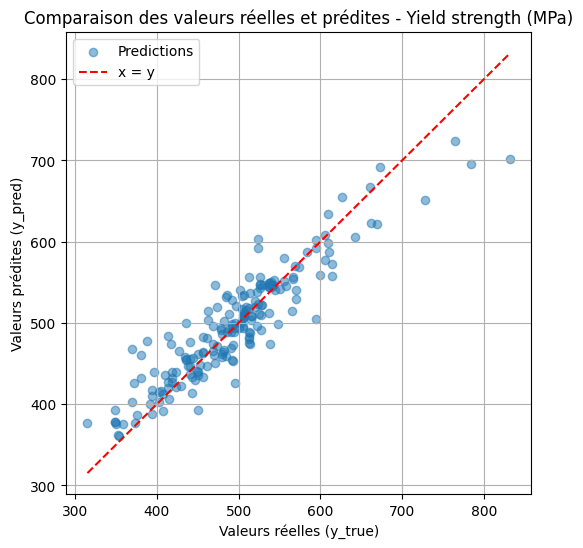

In [170]:
def plot_predictions(dataframe,target_key, col_name_true, col_name_pred):
    """
    Prend un DataFrame, où DataFrame contient deux colonnes : 
    'y_true_test' et 'y_pred_test'. Pour DataFrame, un scatter plot est créé pour 
    comparer les valeurs prédites aux valeurs réelles, et une ligne x=y est tracée.

    Parameters:
    dataframe : pd.DataFrame : DataFrame contenant les valeurs réelles et prédites.
    target_key : str : Clé de la cible.
    col_name_true : str : Nom de la colonne contenant les valeurs réelles.
    col_name_pred : str : Nom de la colonne contenant les valeurs prédites.

    Returns:
    None : Affiche le graphiques du DataFrame.
    """
    df = dataframe[target_key]
    y_true = df[col_name_true]
    y_pred = df[col_name_pred]

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predictions')
    
    # Tracer la ligne x=y
    max_val = max(np.max(y_true), np.max(y_pred))
    min_val = min(np.min(y_true), np.min(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x = y')
    
    plt.title(f'Comparaison des valeurs réelles et prédites - {target_key}')
    plt.xlabel('Valeurs réelles (y_true)')
    plt.ylabel('Valeurs prédites (y_pred)')
    plt.legend()
    plt.grid(True)
    plt.show()

        

plot_predictions(y_preds_dict, 'Yield strength (MPa)', 'y_true_test_Gradient Boosting', 'y_pred_test_Gradient Boosting')

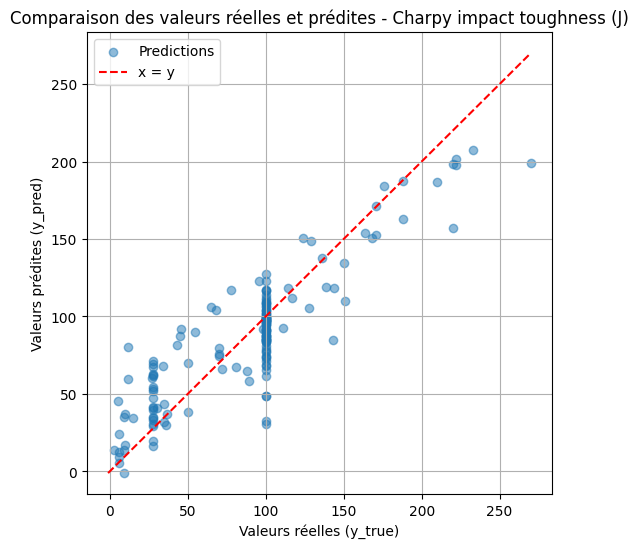

In [171]:
plot_predictions(y_preds_dict,'Charpy impact toughness (J)', 'y_true_test_Gradient Boosting', 'y_pred_test_Gradient Boosting')

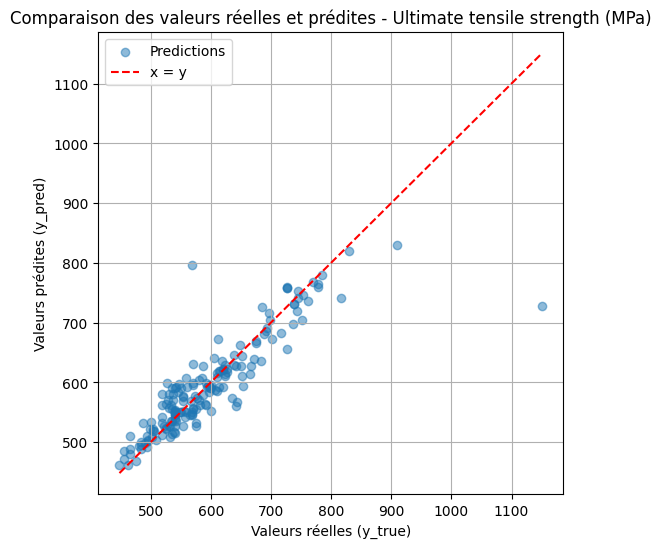

In [172]:
plot_predictions(y_preds_dict, 'Ultimate tensile strength (MPa)', 'y_true_test_Gradient Boosting', 'y_pred_test_Gradient Boosting')

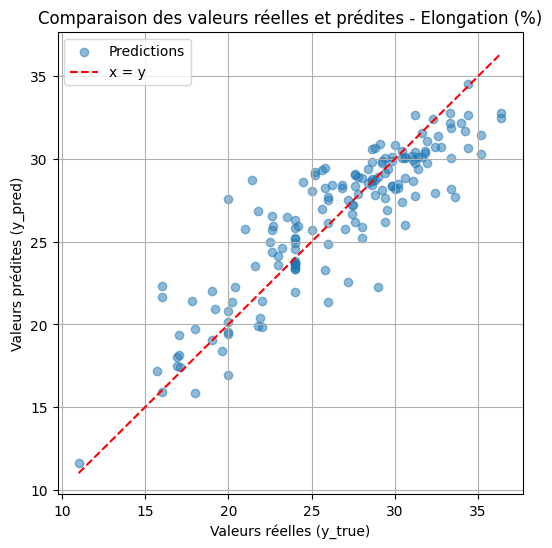

In [173]:
plot_predictions(y_preds_dict, 'Elongation (%)', 'y_true_test_Gradient Boosting', 'y_pred_test_Gradient Boosting')

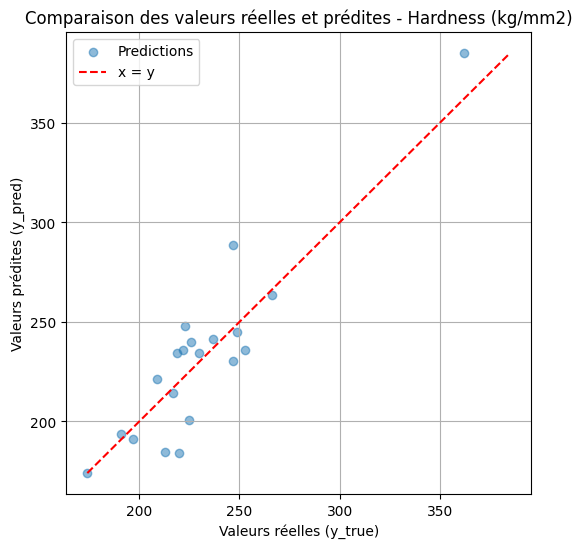

In [174]:
plot_predictions(y_preds_dict, 'Hardness (kg/mm2)', 'y_true_test_Gradient Boosting', 'y_pred_test_Gradient Boosting')

In [13]:
def plot_feature_importances(model, feature_names, top_n=26):
    """
    Affiche les importances des features à partir d'un modèle Random Forest.
    
    :param model: Le modèle RandomForest déjà entraîné
    :param feature_names: La liste des noms des features
    :param top_n: Le nombre de features les plus importantes à afficher (par défaut 10)
    """
    # Extraire les importances des features
    importances = model.feature_importances_
    
    # Créer un DataFrame pour associer les noms des features avec leurs importances
    feature_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # Trier les features par ordre d'importance décroissant
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)
    
    # Si top_n est spécifié, ne garder que les 'top_n' features les plus importantes
    top_features = feature_importances.head(top_n)
    
    # Tracer les importances des features
    plt.figure(figsize=(6, 4))
    plt.barh(np.arange(len(top_features)), top_features['importance'], align='center')
    plt.yticks(np.arange(len(top_features)), top_features['feature'])
    plt.xlabel("Importance")
    plt.title("Top {} Feature Importances".format(top_n))
    plt.gca().invert_yaxis()  # Inverser l'axe Y pour avoir les plus importantes en haut
    plt.show()

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def scale_selected_features(df, feature_list, scaler=MinMaxScaler()):
    """
    Normalise uniquement les colonnes spécifiées dans 'feature_list' et
    renvoie un DataFrame avec ces colonnes normalisées, les autres restant inchangées.
    
    :param df: Le DataFrame d'origine
    :param feature_list: La liste des colonnes à normaliser
    :param scaler: Le scaler à utiliser (par défaut MinMaxScaler)
    :return: Un DataFrame avec les colonnes normalisées
    """
    # Copier le DataFrame original pour éviter de modifier les données d'origine
    df_scaled = df.copy()
    
    # Normaliser uniquement les colonnes dans feature_list
    df_scaled[feature_list] = pd.DataFrame(scaler.fit_transform(df[feature_list]), columns=feature_list, index=df.index)
    
    return df_scaled




<Axes: >

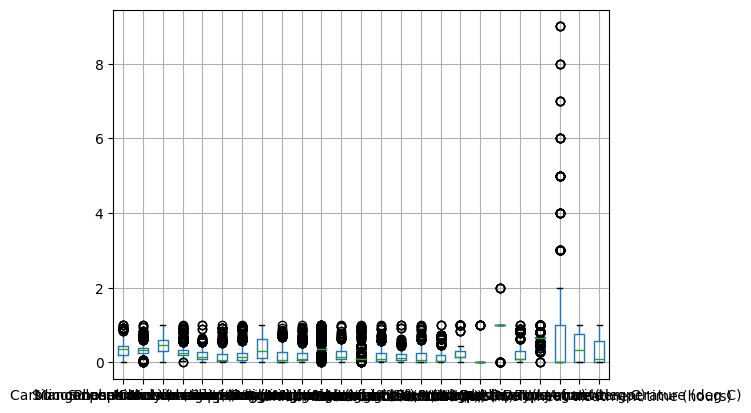

In [14]:
L_features_normalize = [
    'Carbon concentration (weight%)', 'Silicon concentration (weight%)',
       'Manganese concentration (weight%)', 'Sulphur concentration (weight%)',
       'Phosphorus concentration (weight%)', 'Nickel concentration (weight%)',
       'Chromium concentration (weight%)',
       'Molybdenum concentration (weight%)',
       'Vanadium concentration (weight%)', 'Copper concentration (weight%)',
       'Oxygen concentration (%)', 'Titanium concentration (%)',
       'Nitrogen concentration (%)', 'Aluminium concentration (%)',
       'Boron concentration (%)', 'Niobium concentration (%)', 'Current (A)',
       'Voltage (V)',
       'Heat input (kJ/mm)', 'Interpass temperature (deg C)',
       'Post weld heat treatment temperature (deg C)',
       'Post weld heat treatment time (hours)', 
] #'Charpy temperature (deg C)'


df_weld = df.loc[:, L_features + ['Yield strength (MPa)']]
df_weld = df_weld.drop('Charpy temperature (deg C)', axis=1)
df_weld = df_weld.dropna() 
df_weld = df_weld.drop_duplicates()  # Supprimer les doublons


df_scaled = scale_selected_features(df_weld, L_features_normalize)
df_scaled.iloc[:,:-1].boxplot()


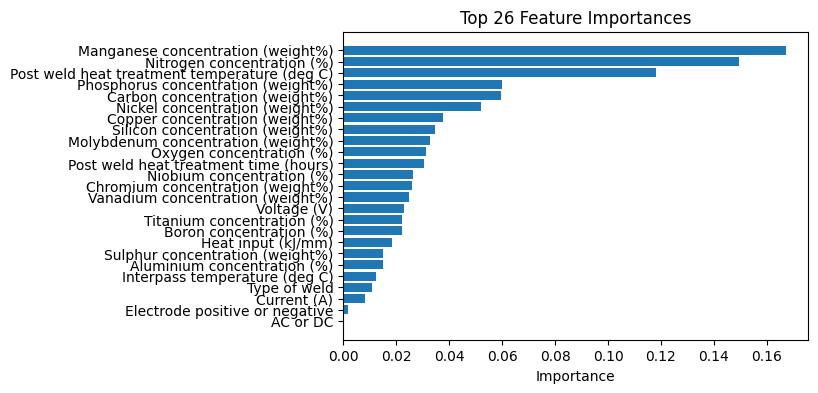

In [15]:
X_scaled = df_scaled.drop('Yield strength (MPa)', axis=1)  # Features
y = df_scaled.loc[:, 'Yield strength (MPa)'] 


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = RandomForestRegressor()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=4, cv=kf, random_state=42)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
# Exemple d'utilisation :
# Supposons que vous ayez déjà un modèle RandomForest entraîné et des noms de features
# rf_model = RandomForestClassifier().fit(X_train, y_train)
plot_feature_importances(best_model, X_train.columns)

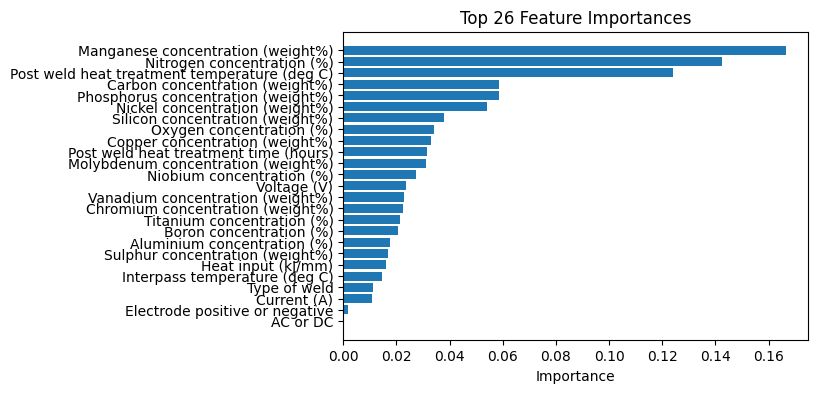

In [16]:
X = df_weld.drop('Yield strength (MPa)', axis=1)  # Features
y = df_weld.loc[:, 'Yield strength (MPa)'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=4, cv=kf, random_state=42)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
# Exemple d'utilisation :
# Supposons que vous ayez déjà un modèle RandomForest entraîné et des noms de features
# rf_model = RandomForestClassifier().fit(X_train, y_train)
plot_feature_importances(best_model, X_train.columns)

In [17]:
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Fonction pour calculer le RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Fonction pour calculer le R² ajusté
def calculate_adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Configuration de la validation croisée (5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Fonction pour entraîner et évaluer le modèle Bayesian Ridge
def bayesian_ridge_regression(X_train, X_test, y_train, y_test):
    model = BayesianRidge()

    # Validation croisée sur l'ensemble d'entraînement
    y_train_pred_cv = cross_val_predict(model, X_train, y_train, cv=kf)

    # Ajustement du modèle et prédictions sur l'ensemble de test
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    # Calcul des scores
    rmse_train = calculate_rmse(y_train, y_train_pred_cv)
    rmse_test = calculate_rmse(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred_cv)
    r2_test = r2_score(y_test, y_test_pred)

    # Nombre d'observations et de prédicteurs
    n_train, p_train = X_train.shape

    return {
        "Model": "Bayesian Ridge",
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test,
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "Adjusted_R2_Train": calculate_adjusted_r2(r2_train, n_train, p_train),
        "Adjusted_R2_Test": calculate_adjusted_r2(r2_test, len(y_test), 1),  # 1 car on a 1 seul prédicteur
        "Hyperparameters": model.get_params()
    }

# Fonction pour entraîner et évaluer le modèle SVR avec Random Grid Search
def svr_regression(X_train, X_test, y_train, y_test):
    model = SVR()
    param_grid = {
        'kernel': ['rbf', 'poly'],
        'C': np.logspace(-3, 3, 7),
        'gamma': ['scale', 'auto'],
        'degree': [2, 3, 4]
    }
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=4, cv=kf, random_state=42)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    # Validation croisée sur l'ensemble d'entraînement
    y_train_pred_cv = cross_val_predict(best_model, X_train, y_train, cv=kf)

    # Prédictions sur l'ensemble de test
    y_test_pred = best_model.predict(X_test)

    # Calcul des scores
    rmse_train = calculate_rmse(y_train, y_train_pred_cv)
    rmse_test = calculate_rmse(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred_cv)
    r2_test = r2_score(y_test, y_test_pred)

    # Nombre d'observations et de prédicteurs
    n_train, p_train = X_train.shape

    return {
        "Model": "SVR",
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test,
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "Adjusted_R2_Train": calculate_adjusted_r2(r2_train, n_train, p_train),
        "Adjusted_R2_Test": calculate_adjusted_r2(r2_test, len(y_test), 1),  # 1 car on a 1 seul prédicteur
        "Hyperparameters": best_model.get_params()
    }

# Fonction pour entraîner et évaluer le modèle de Gradient Boosting avec Random Grid Search
def gradient_boosting_regression(X_train, X_test, y_train, y_test):
    model = GradientBoostingRegressor()
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.05],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10]
    }
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=4, cv=kf, random_state=42)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    # Validation croisée sur l'ensemble d'entraînement
    y_train_pred_cv = cross_val_predict(best_model, X_train, y_train, cv=kf)

    # Prédictions sur l'ensemble de test
    y_test_pred = best_model.predict(X_test)

    # Calcul des scores
    rmse_train = calculate_rmse(y_train, y_train_pred_cv)
    rmse_test = calculate_rmse(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred_cv)
    r2_test = r2_score(y_test, y_test_pred)

    # Nombre d'observations et de prédicteurs
    n_train, p_train = X_train.shape

    return {
        "Model": "Gradient Boosting",
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test,
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "Adjusted_R2_Train": calculate_adjusted_r2(r2_train, n_train, p_train),
        "Adjusted_R2_Test": calculate_adjusted_r2(r2_test, len(y_test), 1),  # 1 car on a 1 seul prédicteur
        "Hyperparameters": best_model.get_params()
    }

# Fonction pour entraîner et évaluer le modèle de Forêt Aléatoire avec Random Grid Search
def random_forest_regression(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor()
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=4, cv=kf, random_state=42)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    # Validation croisée sur l'ensemble d'entraînement
    y_train_pred_cv = cross_val_predict(best_model, X_train, y_train, cv=kf)

    # Prédictions sur l'ensemble de test
    y_test_pred = best_model.predict(X_test)

    # Calcul des scores
    rmse_train = calculate_rmse(y_train, y_train_pred_cv)
    rmse_test = calculate_rmse(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred_cv)
    r2_test = r2_score(y_test, y_test_pred)

    # Nombre d'observations et de prédicteurs
    n_train, p_train = X_train.shape

    return {
        "Model": "Random Forest",
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test,
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "Adjusted_R2_Train": calculate_adjusted_r2(r2_train, n_train, p_train),
        "Adjusted_R2_Test": calculate_adjusted_r2(r2_test, len(y_test), 1),  # 1 car on a 1 seul prédicteur
        "Hyperparameters": best_model.get_params()
    }

# Fonction pour entraîner et évaluer la régression linéaire
def linear_regression(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Validation croisée sur l'ensemble d'entraînement
    y_train_pred_cv = cross_val_predict(model, X_train, y_train, cv=kf)

    # Prédictions sur l'ensemble de test
    y_test_pred = model.predict(X_test)

    # Calcul des scores
    rmse_train = calculate_rmse(y_train, y_train_pred_cv)
    rmse_test = calculate_rmse(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred_cv)
    r2_test = r2_score(y_test, y_test_pred)

    # Nombre d'observations et de prédicteurs
    n_train, p_train = X_train.shape

    return {
        "Model": "Linear Regression",
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test,
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "Adjusted_R2_Train": calculate_adjusted_r2(r2_train, n_train, p_train),
        "Adjusted_R2_Test": calculate_adjusted_r2(r2_test, len(y_test), 1),  # 1 car on a 1 seul prédicteur
        "Hyperparameters": model.get_params()
    }

# Fonction pour entraîner et évaluer la régression Ridge avec Random Grid Search
def ridge_regression(X_train, X_test, y_train, y_test):
    model = Ridge()
    param_grid = {
        'alpha': [0.01, 0.1, 1, 10, 100]
    }
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=4, cv=kf, random_state=42)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    # Validation croisée sur l'ensemble d'entraînement
    y_train_pred_cv = cross_val_predict(best_model, X_train, y_train, cv=kf)

    # Prédictions sur l'ensemble de test
    y_test_pred = best_model.predict(X_test)

    # Calcul des scores
    rmse_train = calculate_rmse(y_train, y_train_pred_cv)
    rmse_test = calculate_rmse(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred_cv)
    r2_test = r2_score(y_test, y_test_pred)

    # Nombre d'observations et de prédicteurs
    n_train, p_train = X_train.shape

    return {
        "Model": "Ridge Regression",
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test,
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "Adjusted_R2_Train": calculate_adjusted_r2(r2_train, n_train, p_train),
        "Adjusted_R2_Test": calculate_adjusted_r2(r2_test, len(y_test), 1),  # 1 car on a 1 seul prédicteur
        "Hyperparameters": best_model.get_params()
    }

# Fonction pour entraîner et évaluer la régression Lasso avec Random Grid Search
def lasso_regression(X_train, X_test, y_train, y_test):
    model = Lasso()
    param_grid = {
        'alpha': [0.01, 0.1, 1, 10, 100]
    }
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=4, cv=kf, random_state=42)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    # Validation croisée sur l'ensemble d'entraînement
    y_train_pred_cv = cross_val_predict(best_model, X_train, y_train, cv=kf)

    # Prédictions sur l'ensemble de test
    y_test_pred = best_model.predict(X_test)

    # Calcul des scores
    rmse_train = calculate_rmse(y_train, y_train_pred_cv)
    rmse_test = calculate_rmse(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred_cv)
    r2_test = r2_score(y_test, y_test_pred)

    # Nombre d'observations et de prédicteurs
    n_train, p_train = X_train.shape

    return {
        "Model": "Lasso Regression",
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test,
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "Adjusted_R2_Train": calculate_adjusted_r2(r2_train, n_train, p_train),
        "Adjusted_R2_Test": calculate_adjusted_r2(r2_test, len(y_test), 1),  # 1 car on a 1 seul prédicteur
        "Hyperparameters": best_model.get_params()
    }


# Fonction principale qui exécute tous les modèles et retourne les résultats dans un DataFrame
def evaluate_all_models(X_train, X_test, y_train, y_test):
    results = []

    # Appel des fonctions de régression et stockage des résultats
    results.append(bayesian_ridge_regression(X_train, X_test, y_train, y_test))
    results.append(svr_regression(X_train, X_test, y_train, y_test))
    results.append(gradient_boosting_regression(X_train, X_test, y_train, y_test))
    results.append(random_forest_regression(X_train, X_test, y_train, y_test))
    results.append(linear_regression(X_train, X_test, y_train, y_test))
    results.append(ridge_regression(X_train, X_test, y_train, y_test))
    results.append(lasso_regression(X_train, X_test, y_train, y_test))
    # Conversion des résultats en DataFrame
    return pd.DataFrame(results)


def evaluateAllTarget(df, Features, Targets):
    progress = 0
    results_dict = {}  # Dictionnaire pour stocker les DataFrames

    # Display a progress bar
    print_progress_bar(progress, int(len(Targets)), prefix='Progress:', suffix='Complete', length=50)

    for i in range(len(Targets)):
        progress += 1
        print_progress_bar(progress, int(len(Targets)), prefix='Progress:', suffix='Complete', length=50)

        col_name = Targets[i]

        # Filtrer les colonnes selon la condition
        if Targets[i] == 'Charpy impact toughness (J)':
            df_weld = df.loc[:, Features + [Targets[i]]]
        else:
            df_weld = df.loc[:, Features + [Targets[i]]]
            df_weld = df_weld.drop('Charpy temperature (deg C)', axis=1)

        df_weld = df_weld.dropna()  # Supprimer les lignes avec des valeurs manquantes
        print(f"\n\nTaille du dataset avant drop duplicates : {col_name} : {df_weld.shape}")
        
        df_weld = df_weld.drop_duplicates()  # Supprimer les doublons
        X = df_weld.drop(Targets[i], axis=1)  # Features
        y = df_weld.loc[:, Targets[i]]  # Target

        print(f"Taille du dataset avec target {col_name} : {df_weld.shape}")

        # Diviser en ensemble d'entraînement et de test
        X_train, X_test, y_train, y_test = train_test_split(X, y)

        print(f"Résultat pour {col_name} avec pour moyenne {y.mean()}: ")

        # Évaluer tous les modèles et obtenir un DataFrame des résultats
        df_results = evaluate_all_models(X_train, X_test, y_train, y_test)

        # Stocker df_results dans le dictionnaire avec col_name comme clé
        results_dict[col_name] = df_results

        print(df_results)

    return results_dict  # Retourner le dictionnaire de DataFrames

results_dict = evaluateAllTarget(df, L_features, L_targets)

"""

'\nimport numpy as np\nimport pandas as pd\nfrom sklearn.model_selection import RandomizedSearchCV, cross_val_predict, KFold\nfrom sklearn.metrics import mean_squared_error, r2_score\nfrom sklearn.linear_model import BayesianRidge\nfrom sklearn.svm import SVR\nfrom sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor\nfrom sklearn.linear_model import LinearRegression, Ridge, Lasso\n\n# Fonction pour calculer le RMSE\ndef calculate_rmse(y_true, y_pred):\n    return np.sqrt(mean_squared_error(y_true, y_pred))\n\n# Fonction pour calculer le R² ajusté\ndef calculate_adjusted_r2(r2, n, p):\n    return 1 - (1 - r2) * (n - 1) / (n - p - 1)\n\n# Configuration de la validation croisée (5 folds)\nkf = KFold(n_splits=5, shuffle=True, random_state=42)\n\n# Fonction pour entraîner et évaluer le modèle Bayesian Ridge\ndef bayesian_ridge_regression(X_train, X_test, y_train, y_test):\n    model = BayesianRidge()\n\n    # Validation croisée sur l\'ensemble d\'entraînement\n    y_tra